In [1]:
import string
import time
import timeit

import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from ordered_set import OrderedSet
import matplotlib.pyplot as plot
import multiprocessing
import pandas as pd
import re

In [2]:
def get_and_clean_data():
    data = pd.read_csv('./resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' '*len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description

def simple_tokenize(data):
    cleaned_description = data.apply(lambda s: [x.strip() for x in s.split()])
    return cleaned_description

def parse_job_description():
    cleaned_description = get_and_clean_data()
    cleaned_description = simple_tokenize(cleaned_description)
    return cleaned_description

In [3]:
def m2_elapsed_set(sample):
    cleaned_description = get_and_clean_data()[:sample]

    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+',' ', s))

    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

    stop_dict = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: list(OrderedSet(s) - stop_dict))
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated: 
        stem_cache[s] = ps.stem(s)
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])


In [4]:
def m2_elapsed_list(sample):
    cleaned_description = get_and_clean_data()[:sample]

    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+',' ', s))

    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

    stop_dict = list(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: [word for word in s if word not in stop_dict])
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated: 
        stem_cache[s] = ps.stem(s)
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

In [6]:
set_exp = {}
list_exp = {}

for w in range(500, 10001, 500): 
    print(w)
    set_exp[w] = timeit.timeit(lambda: m2_elapsed_set(w), number=1)
    list_exp[w] = timeit.timeit(lambda: m2_elapsed_list(w), number=1)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [7]:
pd.DataFrame.from_dict(set_exp, orient='index' ,columns=['set experiment'])

,set experiment
500,3.808745
1000,4.680216
1500,5.695362
2000,6.645932
2500,7.773924
3000,9.305683
3500,10.994535
4000,12.511855
4500,14.110058
5000,15.807285


In [8]:
pd.DataFrame.from_dict(list_exp, orient='index' ,columns=['list experiment'])

,list experiment
500,16.918101
1000,31.817165
1500,47.499886
2000,62.427275
2500,81.997221
3000,105.795248
3500,130.142302
4000,153.542885
4500,181.252230
5000,201.964051


In [9]:
compare = pd.concat([pd.DataFrame.from_dict(set_exp, orient='index', columns=['set experiment']), pd.DataFrame.from_dict(list_exp, orient='index', columns=['list experiment'])], axis=1)
compare

,set experiment,list experiment
500,3.808745,16.918101
1000,4.680216,31.817165
1500,5.695362,47.499886
2000,6.645932,62.427275
2500,7.773924,81.997221
3000,9.305683,105.795248
3500,10.994535,130.142302
4000,12.511855,153.542885
4500,14.110058,181.252230
5000,15.807285,201.964051


Text(0, 0.5, 'elapsed time (s)')

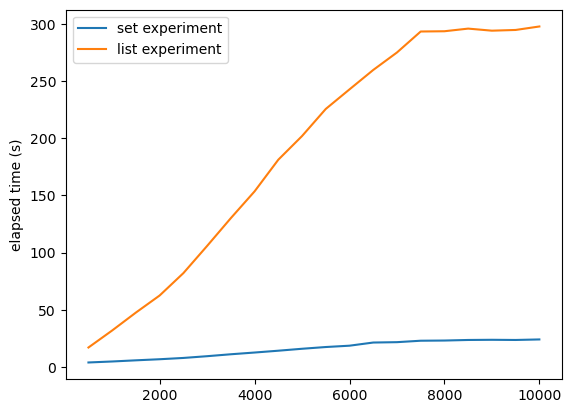

In [10]:
p = compare.plot()
p.set_ylabel('elapsed time (s)')

Text(0, 0.5, 'times (x)')

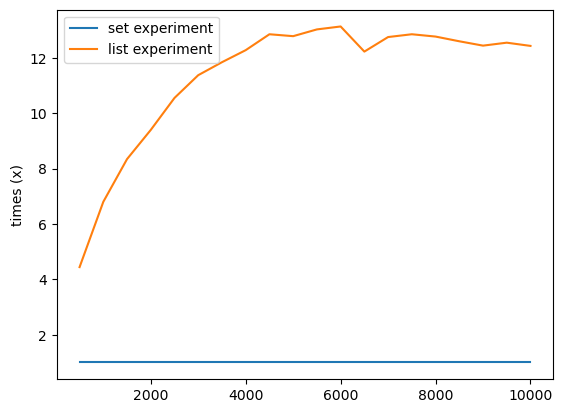

In [11]:
compare['list experiment'] = compare['list experiment'] / compare['set experiment']
compare['set experiment'] = 1
p = compare.plot()
p.set_ylabel('times (x)')

In [12]:
def multicore_list(data):
    print(len(data))
    tokenized_description = data

    stop_dict = list(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: [word for word in s if word not in stop_dict])
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated: 
        stem_cache[s] = ps.stem(s)
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])
    return stemmed_description
    
    
def multicore(data):
    print(len(data))
    tokenized_description = data
    
    stop_dict = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: list(OrderedSet(s) - stop_dict))
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated: 
        stem_cache[s] = ps.stem(s)
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])
    return stemmed_description

In [13]:
parsed_description = parse_job_description()
def core_exp(num_cpus):
        print(num_cpus)
        start = time.time()
        parsed_description_split = np.array_split(parsed_description, num_cpus)
        with multiprocessing.pool.ThreadPool(num_cpus) as p:
            p.map(multicore, parsed_description_split)
        end = time.time()

In [14]:
c = [1,2,4,8,16]
out = []
import time
for core in c:
    start = time.time()
    core_exp(core)
    end = time.time()
    out.append(end - start)

out
    

1
7583


c:\Users\ASUS\anaconda3\envs\se-482\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


2
3792
3791
4
1896
1896
1896
1895
8
948
948
948
948
948
948
948
947
16
474
474
474
474
474
474
474
474
474
474
474
474
474
474
474
473


[16.197161436080933,
 10.220511436462402,
 6.170324802398682,
 5.517818927764893,
 5.7840471267700195]

Text(0, 0.5, 'SpeedUp')

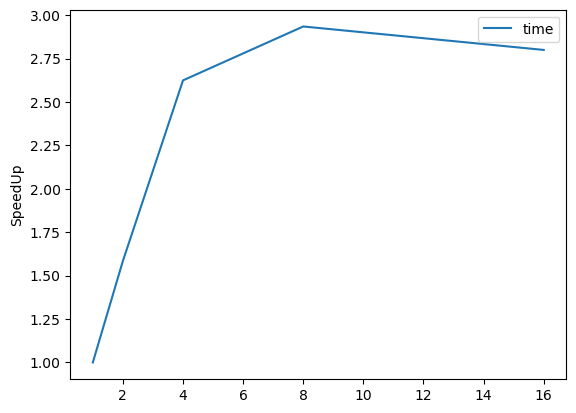

In [15]:
out_dict = {c[n]: out[0]/s for n, s in enumerate(out)}
p = pd.DataFrame.from_dict(out_dict, orient='index', columns=['time']).plot()
p.set_ylabel("SpeedUp")



Text(0, 0.5, 'Time(s)')

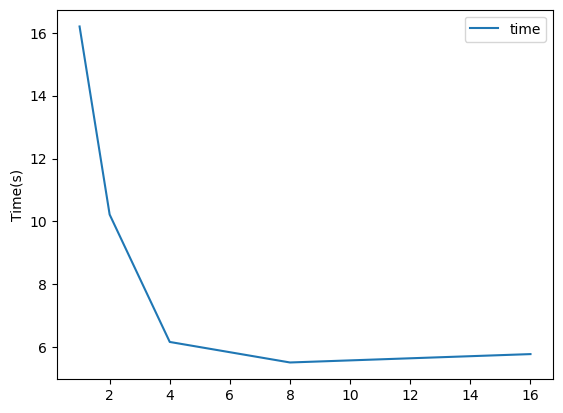

In [16]:
out_dict = {c[n]: s for n, s in enumerate(out)}
p = pd.DataFrame.from_dict(out_dict, orient='index', columns=['time']).plot()
p.set_ylabel("Time(s)")
